In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the dataset
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Reshape input data for neural network
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)


In [3]:
def create_model():
    return tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])


In [4]:
def train_and_evaluate(optimizer, optimizer_name, epochs=10, batch_size=64):
    model = create_model()
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        # Training loop
        for x_batch, y_batch in train_dataset:
            with tf.GradientTape() as tape:
                predictions = model(x_batch, training=True)
                loss = loss_fn(y_batch, predictions)
            gradients = tape.gradient(loss, model.trainable_variables)

            # Apply gradients using the custom or built-in optimizer
            if isinstance(optimizer, (SGD, SGDMomentum, Adam)):
                optimizer.apply_gradients(gradients, model.trainable_variables)
            else:
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Evaluate training accuracy
        train_accuracy = tf.keras.metrics.CategoricalAccuracy()
        for x_batch, y_batch in train_dataset:
            predictions = model(x_batch, training=False)
            train_accuracy.update_state(y_batch, predictions)
        train_accuracies.append(train_accuracy.result().numpy())

        # Evaluate test accuracy
        test_accuracy = tf.keras.metrics.CategoricalAccuracy()
        for x_batch, y_batch in test_dataset:
            predictions = model(x_batch, training=False)
            test_accuracy.update_state(y_batch, predictions)
        test_accuracies.append(test_accuracy.result().numpy())

        print(f"Epoch {epoch + 1}/{epochs}, Optimizer: {optimizer_name}, Train Accuracy: {train_accuracy.result().numpy():.4f}, Test Accuracy: {test_accuracy.result().numpy():.4f}")

    return train_accuracies, test_accuracies


In [5]:
class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate

    def apply_gradients(self, gradients, variables):
        for grad, var in zip(gradients, variables):
            var.assign_sub(self.learning_rate * grad)


In [6]:
class SGDMomentum:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocities = {}

    def apply_gradients(self, gradients, variables):
        for i, (grad, var) in enumerate(zip(gradients, variables)):
            if i not in self.velocities:
                self.velocities[i] = tf.zeros_like(var)
            velocity = self.momentum * self.velocities[i] + grad
            self.velocities[i] = velocity
            var.assign_sub(self.learning_rate * velocity)

In [7]:
class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0

    def apply_gradients(self, gradients, variables):
        self.t += 1
        for i, (grad, var) in enumerate(zip(gradients, variables)):
            if i not in self.m:
                self.m[i] = tf.zeros_like(var)
                self.v[i] = tf.zeros_like(var)

            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * tf.square(grad)

            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)

            var.assign_sub(self.learning_rate * m_hat / (tf.sqrt(v_hat) + self.epsilon))

In [8]:
# Custom optimizers
custom_sgd = SGD(learning_rate=0.01)
custom_sgd_momentum = SGDMomentum(learning_rate=0.01, momentum=0.9)
custom_adam = Adam(learning_rate=0.001)

# Built-in optimizers
tf_sgd = tf.keras.optimizers.SGD(learning_rate=0.01)
tf_sgd_momentum = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
tf_adam = tf.keras.optimizers.Adam(learning_rate=0.001)


In [9]:
# Dictionary to store results
results = {}

# Train with Custom SGD
results["Custom SGD"] = train_and_evaluate(custom_sgd, "Custom SGD")

# Train with Custom SGD with Momentum
results["Custom SGD with Momentum"] = train_and_evaluate(custom_sgd_momentum, "Custom SGD with Momentum")

# Train with Custom Adam
results["Custom Adam"] = train_and_evaluate(custom_adam, "Custom Adam")

# Train with TensorFlow SGD
results["TensorFlow SGD"] = train_and_evaluate(tf_sgd, "TensorFlow SGD")

# Train with TensorFlow SGD with Momentum
results["TensorFlow SGD with Momentum"] = train_and_evaluate(tf_sgd_momentum, "TensorFlow SGD with Momentum")

# Train with TensorFlow Adam
results["TensorFlow Adam"] = train_and_evaluate(tf_adam, "TensorFlow Adam")


Epoch 1/10, Optimizer: Custom SGD, Train Accuracy: 0.8821, Test Accuracy: 0.8894
Epoch 2/10, Optimizer: Custom SGD, Train Accuracy: 0.9066, Test Accuracy: 0.9117
Epoch 3/10, Optimizer: Custom SGD, Train Accuracy: 0.9189, Test Accuracy: 0.9221
Epoch 4/10, Optimizer: Custom SGD, Train Accuracy: 0.9258, Test Accuracy: 0.9287
Epoch 5/10, Optimizer: Custom SGD, Train Accuracy: 0.9326, Test Accuracy: 0.9333
Epoch 6/10, Optimizer: Custom SGD, Train Accuracy: 0.9390, Test Accuracy: 0.9393
Epoch 7/10, Optimizer: Custom SGD, Train Accuracy: 0.9439, Test Accuracy: 0.9431
Epoch 8/10, Optimizer: Custom SGD, Train Accuracy: 0.9469, Test Accuracy: 0.9470
Epoch 9/10, Optimizer: Custom SGD, Train Accuracy: 0.9496, Test Accuracy: 0.9486
Epoch 10/10, Optimizer: Custom SGD, Train Accuracy: 0.9527, Test Accuracy: 0.9514
Epoch 1/10, Optimizer: Custom SGD with Momentum, Train Accuracy: 0.9453, Test Accuracy: 0.9432
Epoch 2/10, Optimizer: Custom SGD with Momentum, Train Accuracy: 0.9628, Test Accuracy: 0.9576

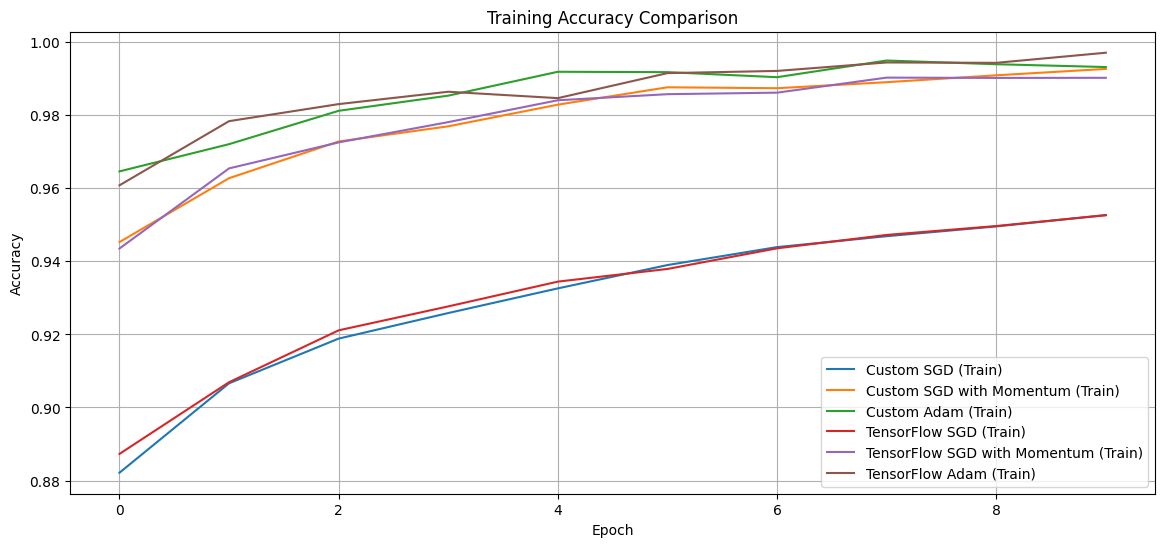

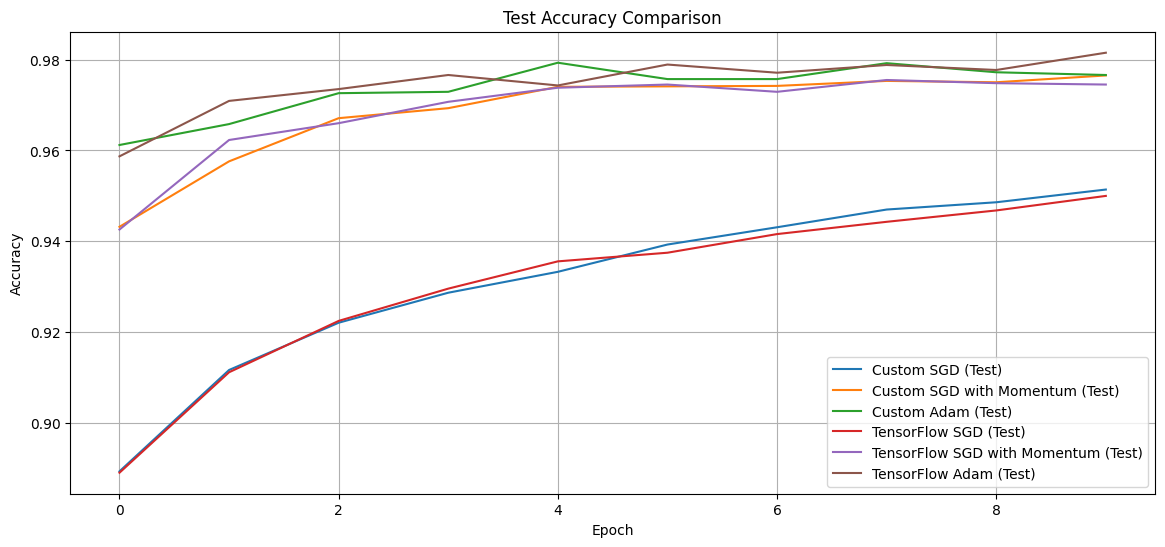

In [10]:
# Plot Training Accuracy
plt.figure(figsize=(14, 6))
for name, (train_accuracies, _) in results.items():
    plt.plot(train_accuracies, label=f"{name} (Train)")
plt.title("Training Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plot Test Accuracy
plt.figure(figsize=(14, 6))
for name, (_, test_accuracies) in results.items():
    plt.plot(test_accuracies, label=f"{name} (Test)")
plt.title("Test Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [25]:
from tabulate import tabulate

print("\nComparison of Final Test Accuracies:")
headers = ["Optimizer", "Custom Acc", "TensorFlow Acc"]
table = []
for name, (_, test_accuracies) in results.items():
    if "Custom" in name:
        optimizer_name = name.split(" ")[-1]
    else:
        optimizer_name = name.split(" ")[-2]
    custom_acc = test_accuracies[-1]
    tf_acc = results[name.replace("Custom", "TensorFlow")][1][-1]
    table.append([optimizer_name, f"{custom_acc:.4f}", f"{tf_acc:.4f}"])
print(tabulate(table[:3], headers=headers, tablefmt="grid"))



Comparison of Final Test Accuracies:
+-------------+--------------+------------------+
| Optimizer   |   Custom Acc |   TensorFlow Acc |
+=============+==============+==================+
| SGD         |       0.9514 |           0.95   |
+-------------+--------------+------------------+
| Momentum    |       0.9765 |           0.9745 |
+-------------+--------------+------------------+
| Adam        |       0.9766 |           0.9815 |
+-------------+--------------+------------------+


In [17]:
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

In [18]:
# Create DataFrame for Training Accuracy
train_data = []
epochs = np.arange(1, 11)
optimizers = ['Custom SGD', 'Custom SGD with Momentum', 'Custom Adam']

for opt in optimizers:
    for epoch, acc in enumerate(results[opt][0], 1):
        train_data.append({
            'Epoch': epoch,
            'Optimizer': opt,
            'Accuracy': acc
        })

df_train = pd.DataFrame(train_data)

# Create interactive 3D plot
fig = px.line_3d(df_train, 
                 x='Epoch', 
                 y='Optimizer', 
                 z='Accuracy',
                 color='Optimizer',
                 title='Training Accuracy Comparison (3D)',
                 labels={'Accuracy': 'Training Accuracy'})

fig.update_traces(line=dict(width=4))
fig.update_layout(
    scene = dict(
        xaxis_title='Epoch',
        yaxis_title='Optimizer',
        zaxis_title='Training Accuracy'
    ),
    width=800,
    height=600,
    showlegend=True
)
fig.show()

In [19]:
# Create DataFrame for Test Accuracy
test_data = []
for opt in optimizers:
    for epoch, acc in enumerate(results[opt][1], 1):
        test_data.append({
            'Epoch': epoch,
            'Optimizer': opt,
            'Accuracy': acc
        })

df_test = pd.DataFrame(test_data)

# Create interactive 3D plot
fig = px.line_3d(df_test, 
                 x='Epoch', 
                 y='Optimizer', 
                 z='Accuracy',
                 color='Optimizer',
                 title='Test Accuracy Comparison (3D)',
                 labels={'Accuracy': 'Test Accuracy'})

fig.update_traces(line=dict(width=4))
fig.update_layout(
    scene = dict(
        xaxis_title='Epoch',
        yaxis_title='Optimizer',
        zaxis_title='Test Accuracy'
    ),
    width=800,
    height=600,
    showlegend=True
)
fig.show()

In [20]:
# Create surface plot data
X, Y = np.meshgrid(epochs, np.arange(len(optimizers)))
Z = np.array([results[opt][0] for opt in optimizers])

# Create interactive surface plot
fig = go.Figure(data=[go.Surface(
    x=X, 
    y=Y, 
    z=Z,
    colorscale='viridis'
)])

fig.update_layout(
    title='Training Accuracy Surface',
    scene = dict(
        xaxis_title='Epoch',
        yaxis_title='Optimizer Index',
        zaxis_title='Training Accuracy',
        yaxis = dict(
            ticktext=optimizers,
            tickvals=list(range(len(optimizers)))
        )
    ),
    width=800,
    height=600
)

fig.show()